Script to simulate hydrodynamics over a river section based on different discharges upstream.

The physical calculations are performed by the analytical model based on the Manning formula, for which stationar and uniform flow is assumed:

    Q=K S^0,5 A R^(2/3)

To do that first the geometric parameters (hydraulic radius, perimeter and surface area) are computed by the function conv_function_basic() based on the input of a criss section('data_bat_csv).

Since we are not always dealing with normal flow a backwatercurve is performed by the Bresse fit
    d = de + (d0-de)2^(L/105) with L05 - 0.24 de /S*d(d0/de)^0,75
    
By Bart Strijker, adapted by Koen Hiemstra. Koen Hiemstra applied a method for Transverse slope and Bedforms.


Version Frederik:
This is a concept model for PhD-research of the Rhine branches. In this case the river stretch Waal.



In [1]:
#In this cell all the needed packages in this script are imported:

import math
from numpy import *
import matplotlib.pyplot as plt
import csv
from scipy.optimize import fsolve,newton
import networkx as nx

In [2]:
#Physical parameters
g=9.81

## Define the parameters of the river system 

In [19]:
#Bathymetry river system: This is a file based on the data of a SOBEK-simulation in 2013 (provided by Max Schropp to Koen Hiemstra).
with open ('River_Waal_data.csv') as f:   #Reading csv file with bathymetry data of the river branches
    reader = csv.reader(f, delimiter=';')
    base_list = list(reader)
    mylist=base_list[1:270]

# Define lists of parameters
    
    point=[]
    name=[]
    x=[]
    y=[]
    kms=[]
    waterlevels=[]
    waterlevels700=[]
    width_summerbed=[]
    level_summerbed=[]
    level_winterbed=[]
    chezy=[]
    nw=[]

    for row in mylist:
        point.append(row [0])
        name.append(row [1])
        x.append(row[2])
        y.append(row[3])
        kms.append(row[5])
        waterlevels.append(row [9])
        waterlevels700.append(row[8])
        width_summerbed.append(row[11])
        level_summerbed.append(row[21])
        level_winterbed.append(row[24])
        chezy.append(row[27])
        nw.append(row[29])

# Change items of list from strings to floating numbers or integer 
location = [int(i) for i in point]
X = [float(i) for i in x] #positie moet nog door 1000 worden gedeeld om oorspronkelijke coordinaten terug te krijgen
Xco = [X[n]/1000 for n in range (0,len(X))]
Y = [float(i) for i in y] #positie moet nog door 1000 worden gedeeld om oorspronkelijke coordinaten terug te krijgen
Yco = [Y[n]/1000 for n in range (0,len(Y))]
KM = [int(i) for i in kms]
Waterlevel = [int(i) for i in waterlevels] #waterlevels in centimeters
Waterlevels700 = [int(i) for i in waterlevels700]#waterlevels in centimeters
Width_summerbed = [int(i) for i in width_summerbed] # width in meter
Level_summerbed = [int(i) for i in level_summerbed] # NAP + centimeters
Level_winterbed = [int(i) for i in level_winterbed] # NAP + centimeters
Chezy = [int(i) for i in chezy]
N = [int(i) for i in nw]
nwaarde = [N[n]/100 for n in range (0,len(N))]

#print(nwaarde)

In [20]:
with open ('Meetpunten RWS.csv') as f:   #Reading csv file with bathymetry data of the river branches
    mreader = csv.reader(f, delimiter=';')
    mbase_list = list(mreader)
    metingen=mbase_list[11:18]
    
    wwaal=[]
    punten=[]
    
for row in metingen: 
    wwaal.append(row[4])
    punten.append(row[3])
    mwaal = [int(i) for i in wwaal]
    meetpunten = [int(i) for i in punten]
    
    #print(myssel, meetpunten)

In [21]:
# Define the different riverstretches of the system
# Bovenrijn = cell 0:8
# Waal = cell 9:195
# Pannerdensch kanaal = cell 196:220
# Nederrijn = cell 221:319
# Lek = cell 320:440
# Yssel = cell 441:669
# Keteldiep = cell 670:679

In [22]:
# A list of the distance along the river between the locations is determined based on the riverlocations and X/Y-coordinates.    
dKM=[KM[n]-KM[n-1] for n in range(1,len(KM))] #distance between the locations
dX=[Xco[n]-Xco[n-1] for n in range(1,len(Xco))]
dY=[Yco[n]-Yco[n-1] for n in range(1,len(Yco))]

#print(dKM)


## Define the hydraulic boundary conditions: incoming river discharge upstream of the river and the downstream water level based on a Q-h relation. 

In [23]:
# This part describes the hydraulic boundary conditions: incoming river discharge upstream of the river and the downstream water level based on a Q-h relation.
# The upstream boundary condition is the incoming riverdischarge at Lobith. At bifurcation Pannerdensche kop a discharge distribution is applied 
# for the discharges into the Waal and the Pannerdensch channel. At the second bifurcation Ysselkop also a discharge distribution to the Nederrijn
# and the Yssel is implemented based on the information provided RWS Oost-Nederland. Information from year 2000 based on measurements 
# of the year 1998 & 1999 for closed barriers in the Nederrijn.

import csv
with open ('DD_Rhinebranches.csv') as f:   #Reading csv file with bathymetry data of the river Waal
    reader = csv.reader(f, delimiter=';')

# Define lists of river discharges
    qlobith=[]
    qwaal=[]
    qpkan=[]
    qneder=[]
    qyssel=[]
    qtotal=[]
        
    for row in reader:    
          
        qlobith.append(row[0]) # incoming discharge Lobith
        qwaal.append(row[1]) # discharge Waal
        qpkan.append(row[2]) # discharge Pannerdensch kanaal
        qneder.append(row[3]) #discharge Nederrijn
        qyssel.append(row[4]) #discharge Yssel

# Change items of list from strings to floating numbers or integer 
Qlob = [int(i) for i in qlobith] 
Qwaal = [int(i) for i in qwaal] 
Qpkan = [int(i) for i in qpkan] 
Qneder = [int(i) for i in qneder] 
Qyssel = [int(i) for i in qyssel]  

#print(Qyssel)    

Qbovenrijn 1013
QPannerdensch Kanaal 200
QWaal 813
QNederrijn 30
QYssel 170


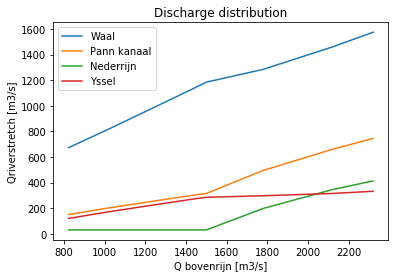

In [24]:
# In this cell the discharge distribution is defined based on the given river discharge of the Bovenrijn.
waal, = plt.plot(Qlob, Qwaal, label='Waal') 
pkan, = plt.plot(Qlob, Qpkan, label='Pann kanaal')               
neder, = plt.plot(Qlob, Qneder, label='Nederrijn') 
yssel, = plt.plot(Qlob, Qyssel, label='Yssel')
plt.title('Discharge distribution')
plt.legend(handles=[waal, pkan, neder, yssel])

plt.ylabel('Qriverstretch [m3/s]')
plt.xlabel('Q bovenrijn [m3/s]')

# River discharge division in case of closed barriers in the range of QLobith=823-1430 m3/s
qbovenrijn=1013

if qbovenrijn==700:
    qpkan=117
    qwaal=583
    qnederrijn=11
    qyssel=106
    bovenrijn_ben=633.2
    pankan_ben=612.7
    waal_ben=69
    neder_ben=600
    yssel_ben=-35
elif qbovenrijn==823:
    qpkan=150
    qwaal=673
    qnederrijn=30
    qyssel=120
    bovenrijn_ben=721.8
    pankan_ben=697.8
    waal_ben=69
    neder_ben=271.6
    yssel_ben=-32.5        
elif qbovenrijn==1013:
    qpkan=200
    qwaal=813
    qnederrijn=30
    qyssel=170
    pankan_ben=697.8
    waal_ben=69
    neder_ben=271.6
    yssel_ben=-32.5
else:
    print('No values.')
    
print('Qbovenrijn',qbovenrijn)
print('QPannerdensch Kanaal',qpkan)
print('QWaal',qwaal)
print('QNederrijn',qnederrijn)
print('QYssel',qyssel)

In [25]:
#Flip arrays for calculation starting at the downstream location of the riverstretch
Xco_flip=Xco[::-1]
Yco_flip=Yco[::-1]
KM_flip=KM[::-1]
dKM_flip=dKM[::-1]
Waterlevel_flip=Waterlevel[::-1]
Waterlevel700_flip=Waterlevels700[::-1]
Width_summerbed_flip=Width_summerbed[::-1]
Level_summerbed_flip=Level_summerbed[::-1]
Level_winterbed_flip=Level_winterbed[::-1] 
Chezy_flip=Chezy[::-1]
nwaarde_flip=nwaarde[::-1]

# Define the different riverstretches of the system
# Bovenrijn = cell 671:681 
xbovenrijn = KM_flip[241:249]
dKMbovenrijn = dKM_flip[241:249]
wlbovenrijn = Waterlevel700_flip[241:249]
wlbovenrijn700 = Waterlevel_flip[241:249]
WSbovenrijn = Width_summerbed_flip [241:249]
LSbovenrijn = Level_summerbed_flip[241:249]
LWbovenrijn = Level_winterbed_flip[241:249]

# Waal1 = cell 484:672
xwaal = KM_flip[0:260]
dKMwaal = dKM_flip[0:260]
wlwaal = Waterlevel_flip[0:260]
wlwaal700 = Waterlevel700_flip[0:260]
WSwaal = Width_summerbed_flip[0:260]
LSwaal = Level_summerbed_flip[0:260]
LWwaal = Level_winterbed_flip[0:260]
Chezywaal = Chezy_flip[0:260]
nwaarde_waal = nwaarde_flip[0:260]


In [26]:
#print(len(dKMwaal))
#print(nwaarde_waal)

260
[0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09,

## Manning formula calculations to determine normal and critical flow depth.

In [44]:
#Channel slope
#According to De Vries (1993), Sieben (2009), Sloff et al.(2014) and Blom (2016), the channel slope of the Waal river is 1.0*10^-4
#and 1.2*10^-4.

S0=0.00012 #bed slope of the rivert
k=1 #roughnesse dependend on discharge
#Roughness of main channel
n=0.0295 
n2=0.08
n3=0.065
C0=1

#Riverstretch Waal & Yssel

#normal flow
def Manning (y, qwaal, b, S, n, k, m):
    A=(b+m*y)*y # conveyance surface area [m2] =>(width*depth)
    R=A/(b+2*y*(1+m**2)**(1/2)) #hydraulic radius [-]
    return qwaal-(C0/n)*A*R**(2/3)*S**(1/2)
m=0


#normal flow depth in steady flow is also upstream water dept of river stretch  
y0_waal = zeros(len(WSwaal))
y0_waal = [fsolve(Manning,1, args=(qwaal, WSwaal[i], S0, 0.06, C0, m)) for i in range (0, len(WSwaal))] 

#bovenstroomse waterstand van een traject dx tov NAP [m]=h_bov_e
waterlevels_normalwaal =zeros(len(y0_waal))
waterlevels_normalwaal = [y0_waal[i]*100+LSwaal[i] for i in range(0, len(y0_waal))] 


## Bresse equation

Based on the Bresse equation the backwatercurve based on the downstream water level can be determined.

In [45]:
# Riverstretch Waal and Yssel
#chezy-coefficient
Cwaal=44
Cyssel=34

#discharge per unit width for each river stretch
qw = [qwaal/WSwaal[n] for n in range (0, len(dKMwaal))] 

#equilibrium water depthfor each river stretch
h_eq_waal = [(qw[n]**2/((Chezywaal[n]**2)*S0))**(1/3)for n in range (0, len(dKMwaal))]
waterlevels_eqwaal = [h_eq_waal[i]*100+LSwaal[i] for i in range(0,len(dKMwaal))] 

#L_05 = [(0.24*cor_h_eq[n]/S0)*(y0[n]/cor_h_eq[n])**(4/3)for n in range (0, len(dKMwaal))] 

#half length for each river stretch
L_05 = [(0.24*h_eq_waal[n]/S0)*(y0_waal[n]/h_eq_waal[n])**(4/3)for n in range (0, len(dKMwaal))] 
L_05_normal_waal = [(0.24*y0_waal[n]/S0)*(y0_waal[n-1]/y0_waal[n])**(4/3)for n in range (0, len(dKMwaal))]

#bodemligging
dd0_waal = [waterlevels_normalwaal[i+1]-waterlevels_normalwaal[i]+dKMwaal[i]*S0 for i in range(0,259)] 


In [46]:
#print(h_eq_yssel[0],L_05_normal_yssel[0],dd0_yssel[0])

In [47]:
# Riverstretch Waal 

hflip_waal = zeros(len(dKMwaal))

#d0_waal = zeros(len(LSwaal))

for i in range (0,259):
    hflip_waal[0]=0
    
    #water level at location x+1  
    hflip_waal[i+1] = waterlevels_normalwaal[i] + (hflip_waal[i]-waterlevels_normalwaal[i]+S0*dKMwaal[i])*(1/2)**(dKMwaal[i]/L_05_normal_waal[i])
    
    waterlevels_waal=hflip_waal#[::-1]
    
    diff_waal = zeros(len(waterlevels_waal))
    diff_waal = [waterlevels_waal[i]-wlwaal[i] for i in range(0,259)]


    #hflip[i+1] = dflip[i] + cor_bl_sum[i]
    #h_wl = hflip[::-1]
    #d0[i+1]=dx_flip[i]*S#d0[i]+

    #dflip[i+1] = y0[i] + (dflip[i]-y0[i])*(1/2)**(dx_flip[i]/L_05_normal[i])#depth at location x+1
    #dd0[i] = [waterlevels_normal[i]-waterlevels[i-1]+dx_flip[i]*S 
    
    #hflip[i+1] = waterlevels_normal[i+1] + (dd0[i]*2)**(dx_flip[i]/L_05_normal[i])#water level at location x+1
    


In [48]:
#print(L_05_normal_waal)

### Module to determine the width-average waterdepth

In [49]:
depth_waal = [(waterlevels_waal[i]-LSwaal[i])/280 for i in range(0,259)]


## Plotting figures of results

Text(0.5,0,'distance, x [m]')

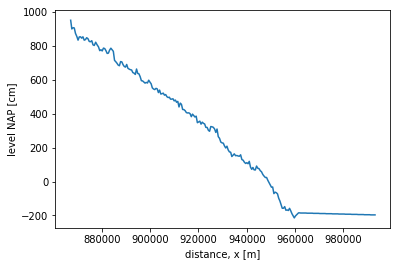

In [50]:
#This cell is added to plot figures based on the determined variables.
plt.figure(1)
plt.plot(xwaal, waterlevels_normalwaal)
plt.ylabel('level NAP [cm]')
plt.xlabel('distance, x [m]')

#plt.figure(2)
#plt.plot(xyssel, waterlevels_normalyssel)
#plt.ylabel('level NAP [cm]')
#plt.xlabel('distance, x [m]')

Text(0.5,0,'distance, x [m]')

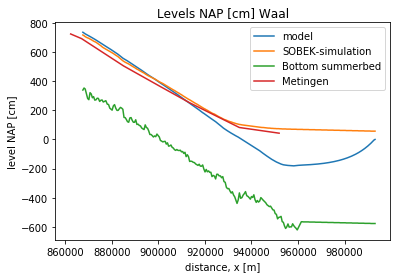

In [51]:
# Plot of riverstretch Waal
plt.figure(4)
#normal, = plt.plot(xyssel, waterlevels_normalyssel, label='norm flow')
model, = plt.plot(xwaal[0:259], waterlevels_waal[0:259], label='model') 
SOBEK, = plt.plot(xwaal[0:259], wlwaal[0:259], label='SOBEK-simulation')
bottom, = plt.plot(xwaal[0:259], LSwaal[0:259], label='Bottom summerbed')
meting, = plt.plot(meetpunten[0:7], mwaal[0:7], label='Metingen')
plt.title('Levels NAP [cm] Waal')
plt.legend(handles=[model, SOBEK, bottom, meting])
plt.ylabel('level NAP [cm]')
plt.xlabel('distance, x [m]')